# Progress 2: Experiment with Regression

## Imports

In [98]:
# Imports
import inspect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.api as sm

## Data Preprocessing
First we load our dataset, then dropping all nan values from the dataset.

Since some of our features are not numerical we have to do some preprocessing to map diet quality to numerical values. 

In [85]:
df = pd.read_csv("enhanced_student_habits_performance_dataset.csv")

df = df[['study_hours_per_day', 'time_management_score', 'motivation_level',
         'attendance_percentage', 'sleep_hours', 'exercise_frequency',
         'diet_quality', 'mental_health_rating', 'stress_level',
         'exam_anxiety_score', 'social_media_hours', 'netflix_hours',
         'screen_time', 'exam_score']].dropna()

df['diet_quality'] = df['diet_quality'].map({
    'Poor':1,
    'Fair':2,
    'Good':3,
    'Excellent':4
})



## Train/Test Split

Here we are dropping exam_scores from the dataset, since exam_scores will be our dependent variable (e.g. the value we are trying to predict).

Leaving only our independent variables:
- study_hours_per_day
- time_management_score
- motivation_level
- attendance_percentage
- sleep_hours
- exercise_frequency
- diet_quality
- mental_health_rating
- stress_level
- exam_anxiety_score
- social_media_hours
- netflix_hours
- screen_time

in our dataset. 

We are also adding a new variable called previous exam average which gets the average of the previous exam scores. Adding this variable made such a difference.

### Create Features and Split Data

In [86]:
X = df.drop('exam_score', axis=1)
y = df['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print(df.columns)
print(df.describe())

Index(['study_hours_per_day', 'time_management_score', 'motivation_level',
       'attendance_percentage', 'sleep_hours', 'exercise_frequency',
       'diet_quality', 'mental_health_rating', 'stress_level',
       'exam_anxiety_score', 'social_media_hours', 'netflix_hours',
       'screen_time', 'exam_score'],
      dtype='object')
       study_hours_per_day  time_management_score  motivation_level  \
count         80000.000000           80000.000000      80000.000000   
mean              4.174388               5.499132          5.488525   
std               2.004135               2.603534          2.867782   
min               0.000000               1.000000          1.000000   
25%               2.800000               3.200000          3.000000   
50%               4.125624               5.500000          5.000000   
75%               5.500000               7.800000          8.000000   
max              12.000000              10.000000         10.000000   

       attendance_percenta

## Fitting the Model

### Defining Models

In [102]:
alphaGrid = np.logspace(-3, 1, 20)

ridge = Ridge(max_iter=5000)
lasso = Lasso(max_iter=5000, random_state=42)
elastic = ElasticNet(max_iter=5000, random_state=42)
decision_tree = DecisionTreeRegressor(random_state=42)
random_forest = RandomForestRegressor(random_state=42,n_jobs=-1)
gradient_boost = GradientBoostingRegressor(random_state=42)

paramGrid = {
    "Ridge": {"alpha": alphaGrid},
    "Lasso": {"alpha": alphaGrid},
    "ElasticNet": {"alpha": alphaGrid, "l1_ratio": [0.2, 0.5, 0.8]},
    "DecisionTree":{
        "max_depth":[10,20,25,30,None],
        "min_samples_split":[2,3,5],
        "min_samples_leaf":[1,2,3],
        "min_impurity_decrease":[0.0,0.0001,0.001]
    },
    "RandomForest":{
        "n_estimators":[100],
        "max_depth":[10,15],
        "min_samples_split": [2],
        "min_samples_leaf": [2],
        "max_features":["sqrt"]
    },
    "GradientBoosting":{
        "n_estimators":[100,200],
        "max_depth":[3,5,7],
        "min_samples_split": [2,5],
    }
}

models = {
    "Ridge": ridge,
    "Lasso": lasso,
    "ElasticNet": elastic,
    "DecisionTree":decision_tree,
    "RandomForest": random_forest,
    "GradientBoosting": gradient_boost
}

### Hyperparameter Tuning with GridSearchCV

In [103]:
bestModels = {}
cvHist = {}

for name, model in models.items():
    grid = GridSearchCV(
        estimator=model,
        param_grid=paramGrid[name],
        cv=5,
        scoring="r2",
        n_jobs=-1,
        return_train_score=True
    )
    grid.fit(X_train, y_train)
    bestModels[name] = grid.best_estimator_
    cvHist[name] = pd.DataFrame(grid.cv_results_)
    print(f"{name}: best={grid.best_params_}  bestCV R2={grid.best_score_:.4f}")

Ridge: best={'alpha': 10.0}  bestCV R2=0.1505
Lasso: best={'alpha': 0.029763514416313176}  bestCV R2=0.1505
ElasticNet: best={'alpha': 0.029763514416313176, 'l1_ratio': 0.8}  bestCV R2=0.1505
DecisionTree: best={'max_depth': 10, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 3, 'min_samples_split': 2}  bestCV R2=0.0512
RandomForest: best={'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}  bestCV R2=0.1443
GradientBoosting: best={'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}  bestCV R2=0.1515


## Results


=== Lasso ===


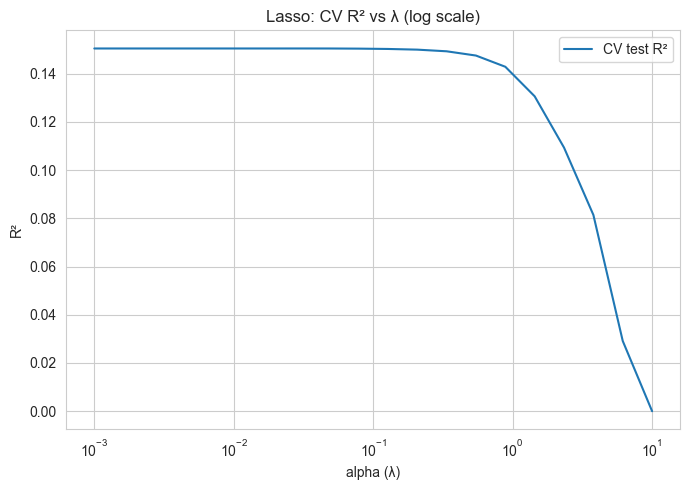

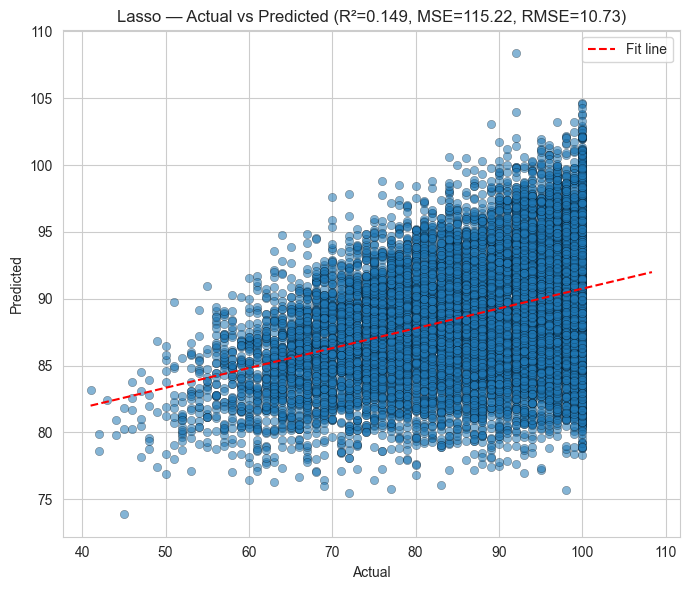


=== Ridge ===


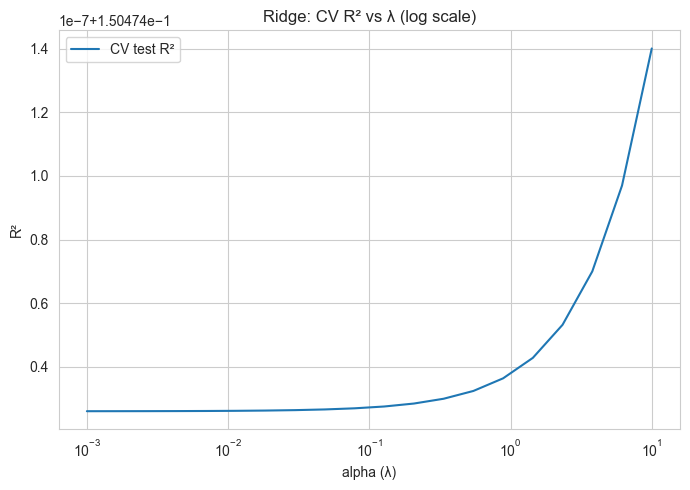

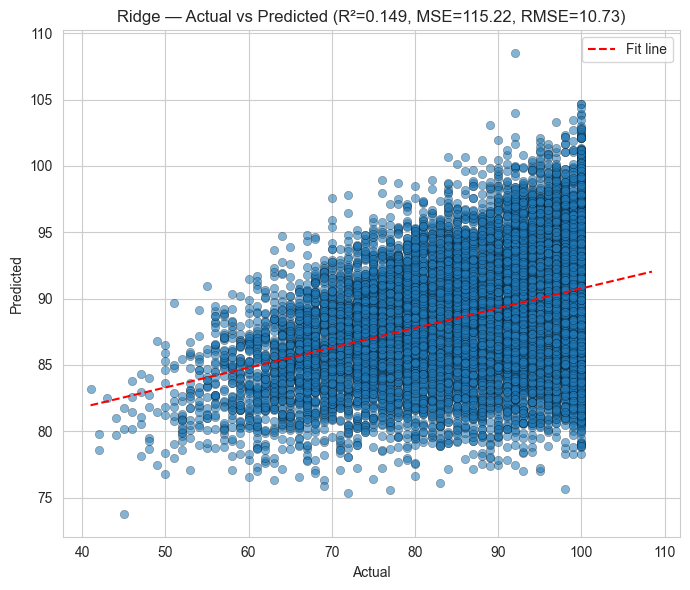


=== ElasticNet ===


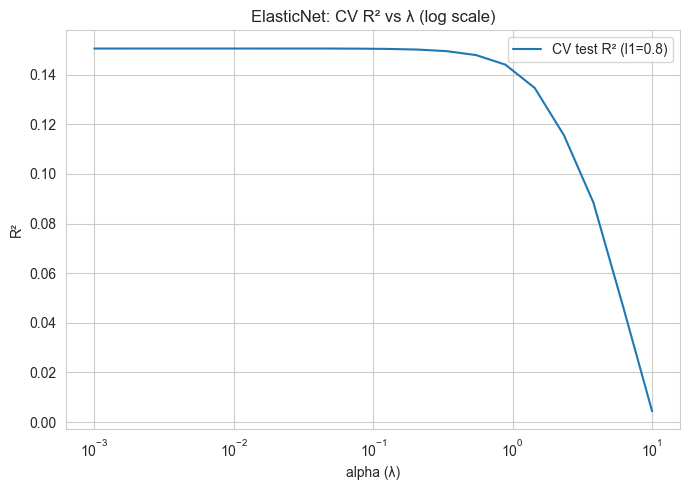

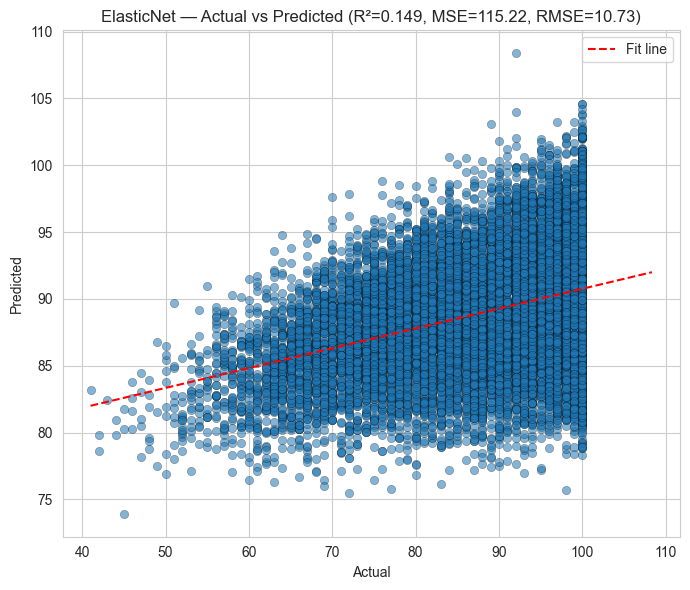


== DecisionTree ===


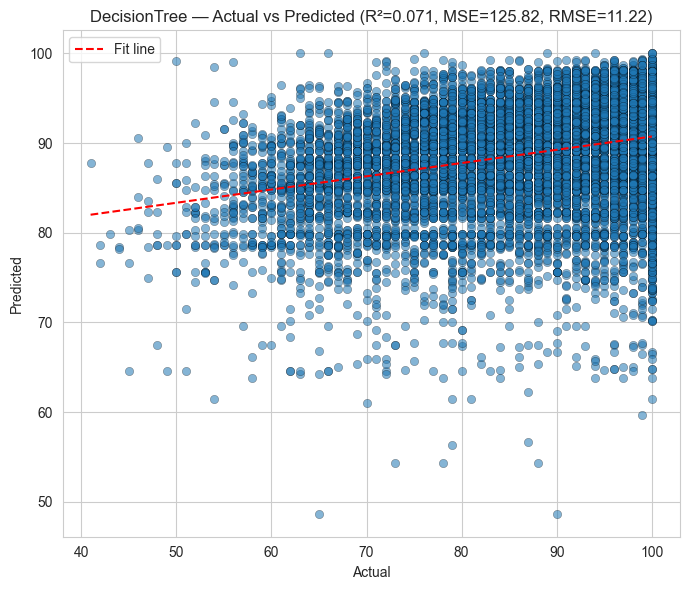

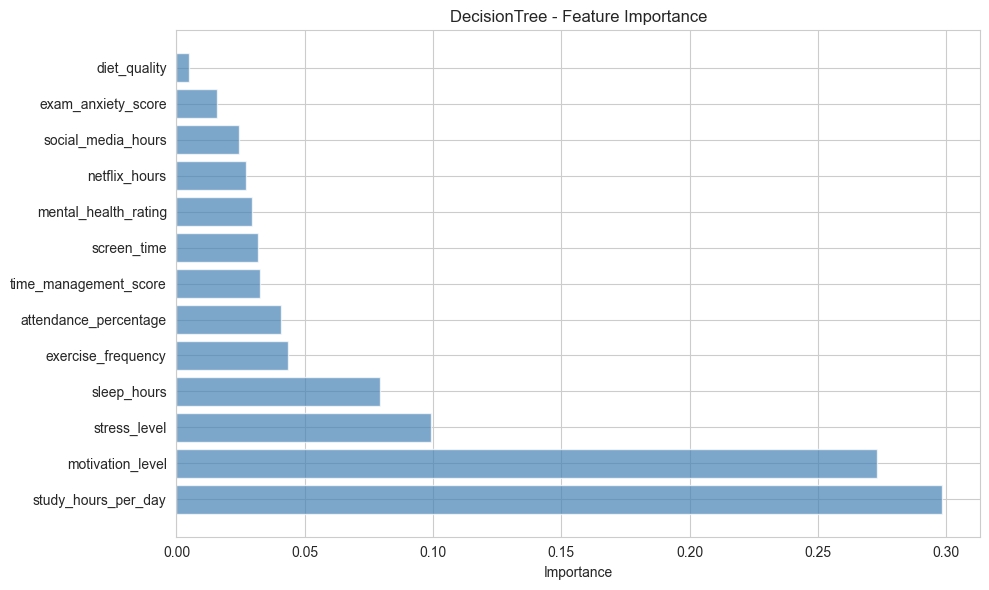


== RandomForest ===


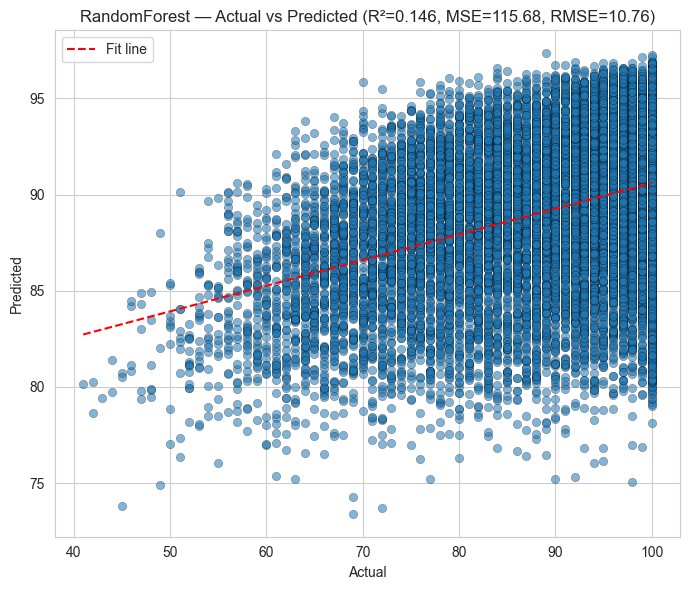

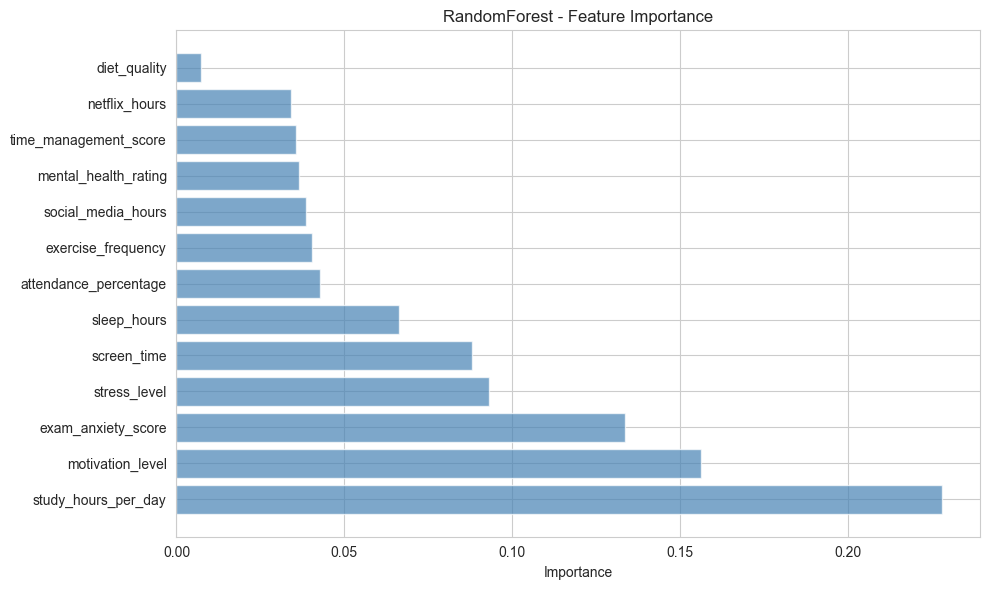

In [94]:
def plot_cv_vs_alpha(name, hist):
    alphaCol = [c for c in hist.columns if c.startswith("param_") and "alpha" in c][0]

    plt.figure(figsize=(7,5))
    if name == "ElasticNet" and "param_l1_ratio" in hist.columns:
        # Use the l1_ratio with best CV score for train/test curves
        bestIdx = hist["mean_test_score"].idxmax()
        bestL1 = hist.loc[bestIdx, "param_l1_ratio"]
        bestHist = hist[hist["param_l1_ratio"] == bestL1].sort_values(alphaCol)
        plt.semilogx(bestHist[alphaCol], bestHist["mean_test_score"], label=f"CV test R² (l1={bestL1})")
    else:
        h = hist[[alphaCol, "mean_test_score"]].dropna().sort_values(alphaCol)
        plt.semilogx(h[alphaCol], h["mean_test_score"], label="CV test R²")

    plt.xlabel("alpha (λ)")
    plt.ylabel("R²")
    if name == "ElasticNet":
        plt.title(f"{name} - 5-fold CV R² vs α (log scale)")
    plt.title(f"{name}: CV R² vs λ (log scale)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_actual_vs_pred(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    plt.figure(figsize=(7,6))
    plt.scatter(y_test, y_pred, alpha=0.55, edgecolor="k", linewidth=0.3)
    
    m, b = np.polyfit(np.asarray(y_test).ravel(), np.asarray(y_pred).ravel(), 1)
    xline = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100)
    
    plt.plot(xline, m*xline + b, "r--", label="Fit line")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} — Actual vs Predicted (R²={r2:.3f}, MSE={mse:.2f}, RMSE={rmse:.2f})")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_feature_importance(name,model,feature_names):
    plt.figure(figsize=(10,6))

    if hasattr(model,'coef_'):
        coeffs = pd.DataFrame({
            "Feature": X_train.columns,
            "Coefficient": model.coef_
        }).sort_values(by="Coefficient", ascending=False)

        colors = ['red' if x < 0 else 'green' for x in coeffs['Coefficient']]
        plt.barh(coeffs['Feature'], coeffs['Coefficient'], color=colors, alpha=0.7)
        plt.xlabel("Coefficient Value")
        plt.title(f"{name} - Feature Coefficients")
    elif hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({
            "Feature":X_train.columns,
            "Importance":model.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        plt.barh(importance['Feature'], importance['Importance'], color='steelblue', alpha=0.7)
        plt.xlabel("Importance")
        plt.title(f"{name} - Feature Importance")

    plt.tight_layout()
    plt.show()
        

# Make both plots for all three models
for name in ["Lasso", "Ridge", "ElasticNet"]:
    print(f"\n=== {name} ===")
    plot_cv_vs_alpha(name, cvHist[name])
    plot_actual_vs_pred(name, bestModels[name], X_test, y_test)

#Plots for tree models
for name in ["DecisionTree", "RandomForest"]:
    print(f"\n== {name} ===")
    plot_actual_vs_pred(name, bestModels[name], X_test, y_test)
    plot_feature_importance(name, bestModels[name], X_train.columns)

### Predictions, Metrics, and Coefficients

In [96]:
for name,model in bestModels.items():
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)
    rmse = np.sqrt(mse)

    print(f"\n{name} Test Performance:")
    print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")

    if hasattr(model,'coef_'):
        coeffs = pd.DataFrame({
            "Feature": X_train.columns,
            "Coefficient": model.coef_
        }).sort_values(by="Coefficient", ascending=False)
        print(coeffs)
    else:
            if hasattr(model, 'feature_importances_'):
                feature_imp = pd.DataFrame({
                    "Feature":X_train.columns,
                    "Importance":model.feature_importances_
                }).sort_values(by='Importance', ascending=False)
                print(feature_imp)


Ridge Test Performance:
MSE: 115.22, RMSE: 10.73, R2: 0.149
                  Feature  Coefficient
0     study_hours_per_day     1.473386
2        motivation_level     0.896578
4             sleep_hours     0.731407
5      exercise_frequency     0.416629
11          netflix_hours     0.115957
10     social_media_hours     0.050128
1   time_management_score     0.020468
3   attendance_percentage     0.002345
7    mental_health_rating    -0.034677
6            diet_quality    -0.064295
12            screen_time    -0.090386
9      exam_anxiety_score    -0.209102
8            stress_level    -0.701288

Lasso Test Performance:
MSE: 115.22, RMSE: 10.73, R2: 0.149
                  Feature  Coefficient
0     study_hours_per_day     1.375837
2        motivation_level     0.907957
4             sleep_hours     0.717863
5      exercise_frequency     0.410907
1   time_management_score     0.016295
11          netflix_hours     0.003306
3   attendance_percentage     0.002250
12            screen

### Interpretation of coefficients

From the above output, we can see how each feature has an effect on the overall prediction, and then how each model deals with features with little impact. We can see that the performance across each model is very similar. Telling us that linear regression wasnt at flaw, and that it must be a case of faulty data. 

We see that Lasso will zero out some of the minor features, where as Ridge keeps them slighlty larget, because it doesnt force zeros. This is probably due to student test perfomance being non-linear, right now we are treating each variable independtly, which is usualy not how exam scores work. If you study for a for a long time, and have high anxiety, you may panic causing poorer performance.

## Ordinary Least Squares (OLS) Regression Results

### Fit OLS and display summary

In [93]:
df = df.dropna(how='any')
X = df.drop(columns=['exam_score'])
X = sm.add_constant(X)
y = df['exam_score']

model = sm.OLS(y,X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             exam_score   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     1090.
Date:                Sat, 29 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:25:11   Log-Likelihood:            -3.0301e+05
No. Observations:               80000   AIC:                         6.060e+05
Df Residuals:                   79986   BIC:                         6.062e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    78.20

## Plotting Results

### Interpretation of OLS results
We can see there are a few features which have a p-value greater than 0.05, meaning they have a negligible effect on the prediction. These features are:
- time_management_score
- attendance_percentage
- mental_health_rating
- social_media_hours
- netflix_hours
- screen_time

## Actual vs. Predicted

### Visualization Settings

In [65]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

### Actual vs. Predicted Scatter Plot

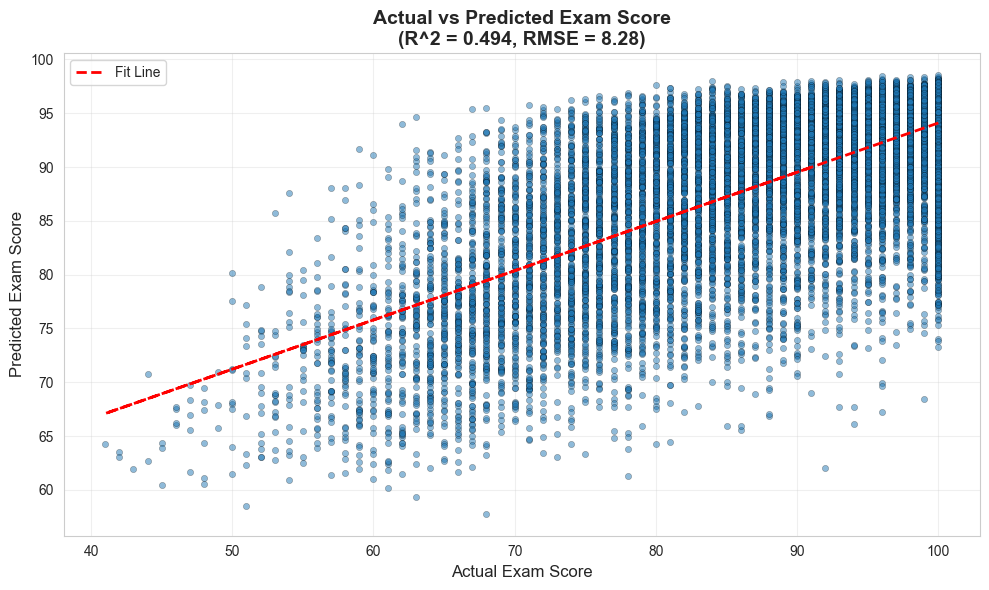

In [66]:
# Actual vs Predicted
plt.figure(figsize=(10,6))

fit = np.polyfit(y_test,y_pred,1)
plt.scatter(y_test,y_pred, alpha=0.5,s=20,edgecolors='k',linewidth=0.3)
plt.plot(y_test,fit[0]*y_test + fit[1], 'r--', lw=2, label='Fit Line')

plt.xlabel('Actual Exam Score', fontsize=12)
plt.ylabel('Predicted Exam Score', fontsize=12)
plt.title(f'Actual vs Predicted Exam Score\n(R^2 = {r2:.3f}, RMSE = {rmse:.2f})',fontsize=14, fontweight='bold')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("Actual_vs_Predicted.png", dpi=300, bbox_inches='tight')
plt.show()

### Final Model Evaluation and Performance

From our analysis we see that R^2 is around 15%. Meaning that only 15% of variance in the exam scores can be exaplined by our features. Meaning that student exam performance maybe influenced by other features not present in our dataset.

Our RMSE value shows that the prediction was ~10.7 points away from the actual score.